# Install and Import Required Libraries


In [ ]:
%pip install tensorflow nibabel dicom2nifti nilearn matplotlib numpy antspyx

In [61]:
import os
import glob
import time
import random
import shutil
import subprocess
import dicom2nifti
import ants
import nibabel as nib
import numpy as np
import nilearn.plotting as plotting
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from collections import defaultdict
from scipy.ndimage import zoom

# Utility functions


In [ ]:
def get_nii_files(base_dir, prefix=None):
    """Retrieve all NIfTI file paths in the directory, optionally filtering by prefix."""
    found = []

    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".nii.gz"):
                file_path = os.path.join(root, file)
                if prefix:
                    if file.startswith(prefix):
                        found.append(file_path)
                else:
                    found.append(file_path)

    return found


def display_nii_stats(base_dir):
    """Display statistics about NIfTI files in the directory"""
    nii_files = get_nii_files(base_dir)
    prefix_counts = {}

    for file in nii_files:
        filename = os.path.basename(file)
        prefix = filename.split("_")[0]
        if prefix in prefix_counts:
            prefix_counts[prefix] += 1
        else:
            prefix_counts[prefix] = 1

    total_files = len(nii_files)

    # Display prefix counts in a pandas grid
    prefix_data = {
        "Prefix": list(prefix_counts.keys()),
        "Count": list(prefix_counts.values()),
    }
    prefix_df = pd.DataFrame(prefix_data)
    prefix_df = prefix_df.sort_values(by="Count", ascending=False)
    prefix_df.loc["Total"] = prefix_df.sum(numeric_only=True)
    print("\nGrid Display for Prefix Counts:")
    display(prefix_df)


def display_comprehensive_stats(base_dir, prefix=""):
    """Display comprehensive statistics about all NIfTI files starting with the given prefix."""
    display_nii_stats(base_dir)

    print(f"Analysing files with prefix '{prefix}'")
    nii_files = get_nii_files(base_dir, prefix=prefix)

    if not nii_files:
        if prefix:
            print(f"No files found with prefix '{prefix}'.")
        else:
            print("No files found.")
        return

    # Plot the first NIfTI file
    first_img = nib.load(nii_files[0])
    plotting.plot_anat(first_img, title=f"Displaying: {nii_files[0]}")
    plotting.show()

    total_files = len(nii_files)
    dimensions = []
    voxel_sizes = []
    orientations = []

    for file in nii_files:
        try:
            img = nib.load(file)
            dimensions.append(img.shape)
            voxel_sizes.append(img.header.get_zooms())
            orientations.append(nib.aff2axcodes(img.affine))
        except Exception as e:
            print(f"Error reading {file}: {e}")

    unique_dimensions = {dim: dimensions.count(dim) for dim in set(dimensions)}
    unique_voxel_sizes = {size: voxel_sizes.count(size) for size in set(voxel_sizes)}
    unique_orientations = {
        orient: orientations.count(orient) for orient in set(orientations)
    }

    # Display in grids
    dim_data = {
        "Dimension": list(unique_dimensions.keys()),
        "Frequency": list(unique_dimensions.values()),
    }
    dim_df = pd.DataFrame(dim_data)
    dim_df["Percentage"] = (dim_df["Frequency"] / total_files * 100).round(1)
    dim_df = dim_df.sort_values(by="Frequency", ascending=False)
    print("\nGrid Display for Dimensions:")
    display(dim_df)

    voxel_data = {
        "Voxel Size": list(unique_voxel_sizes.keys()),
        "Frequency": list(unique_voxel_sizes.values()),
    }
    voxel_df = pd.DataFrame(voxel_data)
    voxel_df["Percentage"] = (voxel_df["Frequency"] / total_files * 100).round(1)
    voxel_df = voxel_df.sort_values(by="Frequency", ascending=False)
    print("\nGrid Display for Voxel Sizes:")
    display(voxel_df)

    orient_data = {
        "Orientation": list(unique_orientations.keys()),
        "Frequency": list(unique_orientations.values()),
    }
    orient_df = pd.DataFrame(orient_data)
    orient_df["Percentage"] = (orient_df["Frequency"] / total_files * 100).round(1)
    orient_df = orient_df.sort_values(by="Frequency", ascending=False)
    print("\nGrid Display for Orientations:")
    display(orient_df)

# Convert dicom to NII


In [ ]:
def convert_dicom_to_nifti(base_dir):
    """Converts DICOM files to NIfTI while preserving folder structure."""
    # Pre-scan directories to convert
    dirs_to_convert = []
    for root, _, files in os.walk(base_dir):
        if any(f.endswith(".dcm") for f in files):
            dirs_to_convert.append((root, files))

    # Process directories with a progress bar
    for root, files in tqdm(
        dirs_to_convert, desc="Converting DICOM to NIfTI", unit="folder"
    ):
        nii_output_dir = root  # Save in the same directory as DICOMs
        nii_output_path = os.path.join(nii_output_dir, "scan.nii.gz")

        if not os.path.exists(nii_output_path):  # Avoid redundant conversion
            try:
                dicom2nifti.convert_directory(
                    root, nii_output_dir, compression=True, reorient=True
                )
                print(f"\nConverted: {root} -> {nii_output_path}")

                # Remove DICOM files after conversion
                for file in files:
                    os.remove(os.path.join(root, file))
            except Exception as e:
                print(f"\nFailed to convert {root}: {e}")


convert_dicom_to_nifti("./data/adni-2-4")

# Split and Name


## rename to image id


In [ ]:
# Change these paths as needed
base_dir = "./data/adni-2-4"

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".nii.gz"):
            # The immediate directory of the file
            parent_dir = os.path.basename(root)
            source_path = os.path.join(root, file)

            # Rename the file to parent's name (.nii.gz)
            target_filename = f"{parent_dir}.nii.gz"
            target_path = os.path.join(base_dir, target_filename)

            print(f"Moving {source_path} to {target_path}")
            shutil.move(source_path, target_path)

## prepend subject id


In [ ]:
def prepend_subject_id_single_dir(data_dir, xml_dir):
    # Create mapping from scan ID to subject ID
    scan_to_subject = {}

    # Parse XML filenames to extract subject ID and scan ID
    print("Creating scan-to-subject mapping...")
    for xml_file in os.listdir(xml_dir):
        if xml_file.endswith(".xml"):
            # From format like "ADNI_013_S_0575_MPRAGE_S28210_I44926.xml"
            # Extract the 013_S_0575 (subject ID) and I44926 (scan ID)
            parts = xml_file.split("_")
            if len(parts) >= 6 and parts[-1].startswith("I"):
                scan_id = parts[-1].split(".")[0]  # e.g., "I44926"
                subject_id = "_".join(parts[1:4])  # e.g., "013_S_0575"
                scan_to_subject[scan_id] = subject_id

    print(f"Found {len(scan_to_subject)} scan-to-subject mappings")

    # Process all nii.gz files in the provided data_dir
    for file_path in glob.glob(os.path.join(data_dir, "*.nii.gz")):
        file_name = os.path.basename(file_path)
        scan_id = file_name.split(".")[0]  # e.g., "I44926"

        if scan_id in scan_to_subject:
            subject_id = scan_to_subject[scan_id]
            new_name = f"{subject_id}_{file_name}"
            new_path = os.path.join(data_dir, new_name)
            print(f"Renaming {file_name} to {new_name}")
            os.rename(file_path, new_path)
        else:
            print(f"Could not find subject ID for scan {scan_id}")

    print("File renaming complete!")


# Example usage:
prepend_subject_id_single_dir("./data/adni-2-4", "./data/metadata")

## Split by research group


In [ ]:
def get_research_group(xml_path):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for elem in root.iter("researchGroup"):
            return elem.text
    except Exception as e:
        print(f"Error parsing {xml_path}: {e}")
    return None


def restructure_dataset(data_dir, metadata_dir, output_dir):
    # Create output subdirectories for AD and CN
    for group in ["AD", "CN"]:
        os.makedirs(os.path.join(output_dir, group), exist_ok=True)

    # Process each nii.gz file in the data_dir
    print("Processing nii.gz files...")
    for file_path in glob.glob(os.path.join(data_dir, "*.nii.gz")):
        file_name = os.path.basename(file_path)

        # Assume filename format: subjectID_imageID.nii.gz; extract imageID
        parts = file_name.split("_")
        # If the image ID is at the end (removing extension)
        image_id = parts[-1].split(".")[0] if parts else file_name.split(".")[0]

        # Locate corresponding XML file in the metadata_dir
        xml_file = None
        for candidate in os.listdir(metadata_dir):
            if candidate.endswith(f"{image_id}.xml"):
                xml_file = candidate
                break

        if xml_file:
            xml_path = os.path.join(metadata_dir, xml_file)
            group = get_research_group(xml_path)
            if group in {"AD", "CN"}:
                dest_path = os.path.join(output_dir, group, file_name)
                print(f"Copying {file_name} to {group} folder")
                shutil.copy(file_path, dest_path)
            else:
                print(f"Research group for {file_name} is invalid: {group}")
        else:
            print(f"No XML found for {file_name}")

    print("Restructuring complete!")


# Example usage:
restructure_dataset("./data/adni-2-4", "./data/metadata", "./data/adni-2-4-cond")

## Filter files by subject spread

I used this to get a certain number of files from the CN folder because I wanted to make the split 50/50 which meant only picking 107 files, but I wanted them to come from as wide an arrray of subjects as possible


In [ ]:
def filter_files_wide_spread(data_dir, output_dir, count=100):
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Get list of nii.gz files in data_dir
    files = glob.glob(os.path.join(data_dir, "*.nii.gz"))

    # Group files by subject id (subject id is everything up to the last underscore)
    subject_files = {}
    for file_path in files:
        filename = os.path.basename(file_path)
        parts = filename.split("_")
        if len(parts) < 2:
            continue  # Skip files that do not follow the expected naming format.
        # Subject id is defined as everything until the last underscore.
        subject_id = "_".join(parts[:-1])
        subject_files.setdefault(subject_id, []).append(file_path)

    selected_files = []
    subjects = list(subject_files.keys())

    # Case 1: We have at least "count" distinct subjects.
    if len(subjects) >= count:
        # Randomly choose count subjects and from each choose one random file.
        chosen_subjects = random.sample(subjects, count)
        for subj in chosen_subjects:
            chosen_file = random.choice(subject_files[subj])
            selected_files.append(chosen_file)
    else:
        # Case 2: fewer than count subjects.
        # First, select one file from each subject.
        for subj in subjects:
            chosen_file = random.choice(subject_files[subj])
            selected_files.append(chosen_file)

        # Now fill up remainder from subjects that have extra files.
        remaining = count - len(selected_files)
        # Prepare a list of iterators for subjects with more than one file.
        extra_files = []
        for subj in subjects:
            # Add extra files (exclude the one already used)
            files_for_subj = subject_files[subj][:]
            if len(files_for_subj) > 1:
                # Remove the file already selected (if present)
                file_already = selected_files.pop(
                    0
                )  # this line ensures we don't accidentally select the same file by accident.
                files_for_subj = [f for f in subject_files[subj] if f != file_already]
                selected_files.insert(0, file_already)
                extra_files.append(files_for_subj)
            else:
                extra_files.append([])

        # Flatten extra_files while preserving the order of subjects
        # Use round-robin style selection.
        added = 0
        while added < remaining:
            any_added = False
            for subj, files_list in zip(subjects, extra_files):
                if files_list:
                    selected_files.append(files_list.pop(0))
                    added += 1
                    any_added = True
                    if added >= remaining:
                        break
            if not any_added:
                # No more extra files available.
                break

    # Copy the selected files to the output directory
    for file_path in selected_files:
        file_name = os.path.basename(file_path)
        dest_path = os.path.join(output_dir, file_name)
        print(f"Copying {file_name} to {output_dir}")
        shutil.copy(file_path, dest_path)

    print("File filtering complete!")


# Example usage:
filter_files_wide_spread(
    "./data/adni-2-4-cond/CN", "./data/adni-2-4-cond/CN-filtered", count=107
)

# Skull Stripping


In [19]:
def run_synthstrip(freesurfer_home, input_path, ss_output_path):
    """Runs SynthStrip on a single NIfTI file."""
    if os.path.exists(ss_output_path):  # Avoid redundant processing
        print(f"Skipping {input_path}, output already exists.")
        return

    try:
        env = os.environ.copy()
        env["FREESURFER_HOME"] = freesurfer_home
        env["SUBJECTS_DIR"] = os.path.join(freesurfer_home, "subjects")

        command = [
            "/bin/bash",
            "-c",  # Use bash explicitly
            f"source {freesurfer_home}/SetUpFreeSurfer.sh && "
            f"mri_synthstrip -i {input_path} -o {ss_output_path}",
        ]

        start_time = time.time()
        subprocess.run(command, check=True, env=env)
        elapsed_time = time.time() - start_time

        print(
            f"✔ Processed: {input_path} -> {ss_output_path} (Time: {elapsed_time:.2f}s)"
        )

        # Delete the original file after successful processing
        os.remove(input_path)
        print(f"🗑️ Deleted original file: {input_path}")

    except subprocess.CalledProcessError as e:
        print(f"❌ Failed to process {input_path}: {e}")


def skull_strip_nifti(base_dir, freesurfer_home="/Applications/freesurfer/7.4.1"):
    """Runs SynthStrip on NIfTI files sequentially while preserving folder structure."""
    tasks = []

    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".nii.gz") and not file.startswith("ss_"):
                input_path = os.path.join(root, file)
                ss_output_path = os.path.join(root, "ss_" + file)
                tasks.append((freesurfer_home, input_path, ss_output_path))

    total_tasks = len(tasks)
    if total_tasks == 0:
        print("✅ No new NIfTI files to process.")
        return

    print(f"🔍 Found {total_tasks} files to process.")

    start_time = time.time()

    # Process tasks sequentially
    for i, task in enumerate(tasks):
        print(f"[{i+1}/{total_tasks}] Processing: {task[1]}")
        try:
            run_synthstrip(*task)
        except Exception as e:
            print(f"⚠️ Error processing {task[1]}: {e}")

    elapsed_time = time.time() - start_time
    print(f"✅ Finished processing all files in {elapsed_time:.2f}s.")


skull_strip_nifti("./data/adni-2-4-cond")

🔍 Found 451 files to process.
[1/451] Processing: ./data/adni-2-4-cond/AD/135_S_4676_I298456.nii.gz
Configuring model on the CPU
Running SynthStrip model version 1
Input image read from: ./data/adni-2-4-cond/AD/135_S_4676_I298456.nii.gz
Processing frame (of 1): 1 done
Masked image saved to: ./data/adni-2-4-cond/AD/ss_135_S_4676_I298456.nii.gz

If you use SynthStrip in your analysis, please cite:
----------------------------------------------------
SynthStrip: Skull-Stripping for Any Brain Image
A Hoopes, JS Mora, AV Dalca, B Fischl, M Hoffmann
NeuroImage 206 (2022), 119474
https://doi.org/10.1016/j.neuroimage.2022.119474 

Website: https://w3id.org/synthstrip

✔ Processed: ./data/adni-2-4-cond/AD/135_S_4676_I298456.nii.gz -> ./data/adni-2-4-cond/AD/ss_135_S_4676_I298456.nii.gz (Time: 149.79s)
🗑️ Deleted original file: ./data/adni-2-4-cond/AD/135_S_4676_I298456.nii.gz
[2/451] Processing: ./data/adni-2-4-cond/AD/011_S_4912_I363474.nii.gz
Configuring model on the CPU
Running SynthStrip mo


Grid Display for Prefix Counts:


,Prefix,Count
0,ss,451.0
Total,NaN,451.0


Analysing files with prefix ''


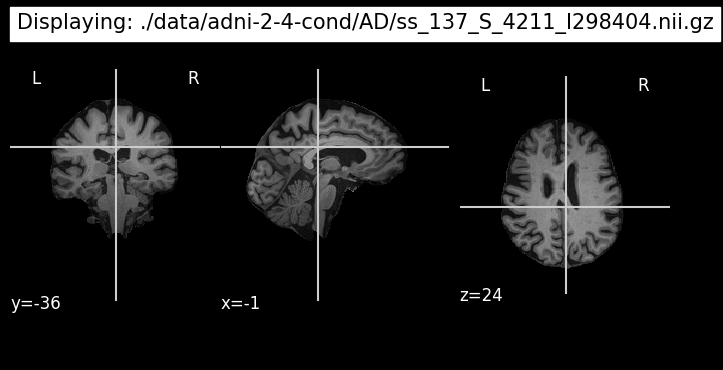


Grid Display for Dimensions:


,Dimension,Frequency,Percentage
5,"(176, 240, 256)",288,63.9
2,"(170, 256, 256)",144,31.9
1,"(160, 192, 192)",14,3.1
0,"(176, 248, 256)",2,0.4
3,"(160, 240, 256)",2,0.4
4,"(176, 256, 256)",1,0.2



Grid Display for Voxel Sizes:


,Voxel Size,Frequency,Percentage
2,"(1.1999999, 1.0, 1.0)",286,63.4
5,"(1.199997, 1.0, 1.0)",86,19.1
9,"(1.2000046, 1.0, 1.0)",52,11.5
4,"(1.2, 1.25, 1.25)",14,3.1
6,"(1.1999999, 1.0546875, 1.0546875)",5,1.1
1,"(1.2, 1.0, 1.0)",2,0.4
0,"(1.2000003, 1.0, 1.0)",1,0.2
3,"(1.2000021, 1.0, 1.0)",1,0.2
7,"(1.200004, 1.0, 1.0)",1,0.2
8,"(1.1999981, 1.0, 1.0)",1,0.2



Grid Display for Orientations:


,Orientation,Frequency,Percentage
0,"(L, A, S)",451,100.0


In [33]:
display_comprehensive_stats("./data/adni-2-4-cond")

# Spatial Normalisation


## Reasons I do NOT Need Spatial Normalization

1. ADNI-1 T1W data is already preprocessed
   - ADNI follows a standardized acquisition protocol, ensuring consistent voxel sizes and orientations across patients.
   - If you’re only using ADNI-1 (no ADNI-2 or ADNI-3), there’s less variation in scanner settings, meaning alignment might already be sufficient.
2. CNNs Learn Spatial Features
   - If you're using a deep learning model (e.g., CNN), it can learn spatial variations on its own.
   - Adding spatial normalization could remove subtle differences in brain shape that might be relevant for classification.
3. Preserving Native Brain Shape
   - Some models benefit from analyzing brain atrophy without forced alignment to MNI space.
   - If you want to measure structural differences in their original form (e.g., hippocampal shrinkage), keeping scans in native space may be better.


# Voxel Standardisation



Grid Display for Prefix Counts:


,Prefix,Count
0,ss,451.0
Total,NaN,451.0


Analysing files with prefix ''


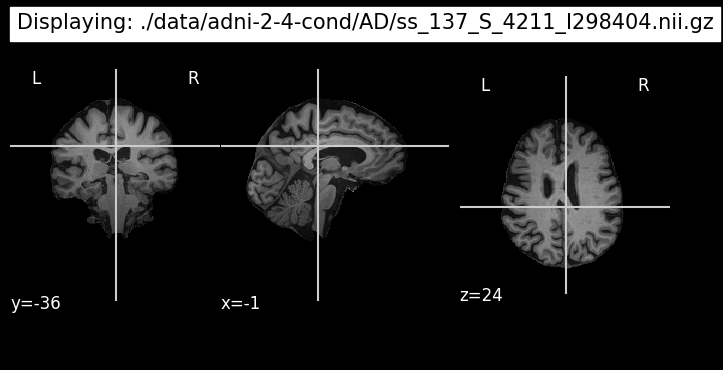


Grid Display for Dimensions:


,Dimension,Frequency,Percentage
5,"(176, 240, 256)",287,63.6
2,"(170, 256, 256)",144,31.9
1,"(160, 192, 192)",14,3.1
0,"(176, 248, 256)",2,0.4
3,"(160, 240, 256)",2,0.4
4,"(176, 256, 256)",1,0.2
6,"(211, 240, 256)",1,0.2



Grid Display for Voxel Sizes:


,Voxel Size,Frequency,Percentage
2,"(1.1999999, 1.0, 1.0)",285,63.2
5,"(1.199997, 1.0, 1.0)",86,19.1
9,"(1.2000046, 1.0, 1.0)",52,11.5
4,"(1.2, 1.25, 1.25)",14,3.1
6,"(1.1999999, 1.0546875, 1.0546875)",5,1.1
1,"(1.2, 1.0, 1.0)",2,0.4
0,"(1.2000003, 1.0, 1.0)",1,0.2
3,"(1.2000021, 1.0, 1.0)",1,0.2
7,"(1.200004, 1.0, 1.0)",1,0.2
8,"(1.1999981, 1.0, 1.0)",1,0.2



Grid Display for Orientations:


,Orientation,Frequency,Percentage
0,"(L, A, S)",451,100.0


In [38]:
display_comprehensive_stats("./data/adni-2-4-cond")

Resampled and saved: ./data/adni-2-4-cond/AD/resampled_ss_137_S_4211_I298404.nii.gz
Original resolution: (1.0, 1.0, 1.0)
Resampled resolution: (1.0, 1.0, 1.0)


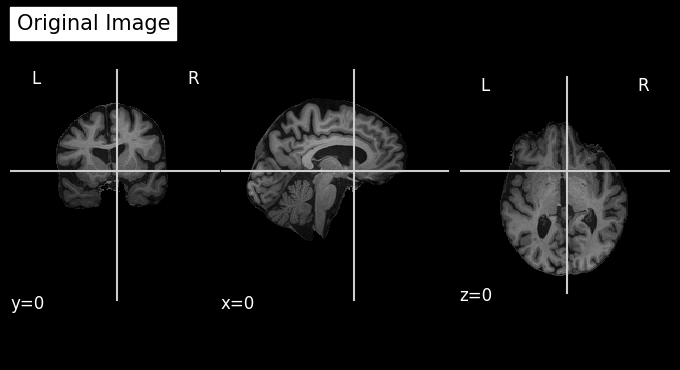

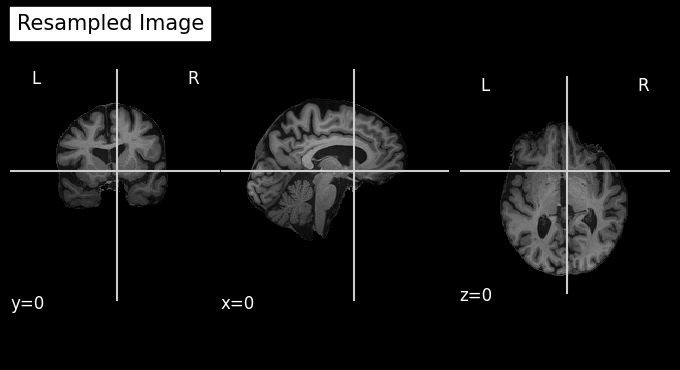

In [39]:
def resample(file_path, output_path, target=(1, 1, 1)):
    """Resample a NIfTI file to 1x1x1 mm voxel size using ANTs."""
    try:
        # Load the image
        img = ants.image_read(file_path)

        # Resample the image to 1x1x1 mm voxel size
        resampled_img = ants.resample_image(img, target, use_voxels=False)

        # Save the resampled image
        ants.image_write(resampled_img, output_path)
        print(f"Resampled and saved: {output_path}")

    except Exception as e:
        print(f"Error resampling {file_path}: {e}")


def test_resample_single_image(file_path):
    """Test resampling on a single image and display the outputs."""
    resampled_file_path = file_path.replace("ss_", "resampled_ss_")
    resample(file_path, resampled_file_path)

    # Load the original and resampled images
    original_img = nib.load(file_path)
    resampled_img = nib.load(resampled_file_path)

    # Display the resolutions
    original_resolution = original_img.header.get_zooms()
    resampled_resolution = resampled_img.header.get_zooms()
    print(f"Original resolution: {original_resolution}")
    print(f"Resampled resolution: {resampled_resolution}")

    # Plot the middle slice of the original scan
    plotting.plot_anat(original_img, title="Original Image", cut_coords=(0, 0, 0))
    plt.show()

    # Plot the middle slice of the resampled scan
    plotting.plot_anat(resampled_img, title="Resampled Image", cut_coords=(0, 0, 0))
    plt.show()


# Test the resampling on a single image
test_resample_single_image(get_nii_files("./data/adni-2-4-cond", prefix="ss_")[0])

In [41]:
def resample_all_ss_files(base_dir):
    """Resample all ss NIfTI files in the directory to 1x1x1 mm voxel size."""
    ss_files = get_nii_files(base_dir, prefix="ss_")
    for file_path in ss_files:
        resampled_file_path = file_path.replace("ss_", "resampled_ss_")
        if not os.path.exists(resampled_file_path):
            resample(file_path, resampled_file_path)
        else:
            print(f"Skipping {file_path}, resampled file already exists.")


resample_all_ss_files("./data/adni-2-4-cond")

Skipping ./data/adni-2-4-cond/AD/ss_137_S_4211_I298404.nii.gz, resampled file already exists.
Resampled and saved: ./data/adni-2-4-cond/AD/resampled_ss_116_S_4209_I269335.nii.gz
Resampled and saved: ./data/adni-2-4-cond/AD/resampled_ss_006_S_4192_I258594.nii.gz
Resampled and saved: ./data/adni-2-4-cond/AD/resampled_ss_130_S_4660_I342228.nii.gz
Resampled and saved: ./data/adni-2-4-cond/AD/resampled_ss_130_S_4730_I376250.nii.gz
Resampled and saved: ./data/adni-2-4-cond/AD/resampled_ss_033_S_5017_I375609.nii.gz
Resampled and saved: ./data/adni-2-4-cond/AD/resampled_ss_070_S_4692_I302279.nii.gz
Resampled and saved: ./data/adni-2-4-cond/AD/resampled_ss_114_S_4379_I277487.nii.gz
Resampled and saved: ./data/adni-2-4-cond/AD/resampled_ss_128_S_4774_I311833.nii.gz
Resampled and saved: ./data/adni-2-4-cond/AD/resampled_ss_073_S_5016_I342679.nii.gz
Resampled and saved: ./data/adni-2-4-cond/AD/resampled_ss_137_S_4211_I394287.nii.gz
Resampled and saved: ./data/adni-2-4-cond/AD/resampled_ss_116_S_42


Grid Display for Prefix Counts:


,Prefix,Count
0,ss,451.0
1,resampled,451.0
Total,NaN,902.0


Analysing files with prefix 'resampled'


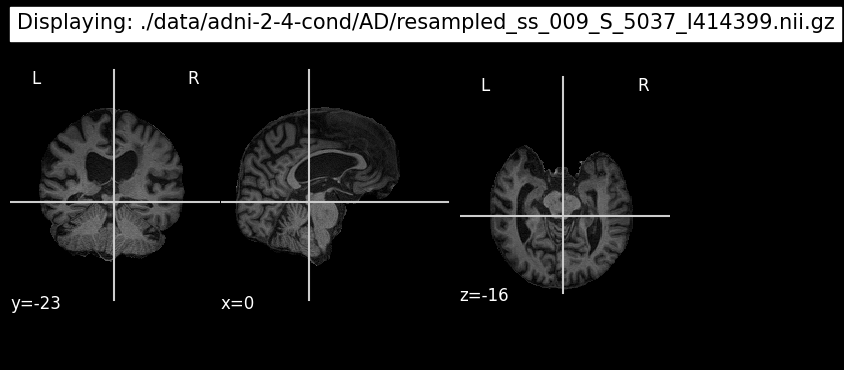


Grid Display for Dimensions:


,Dimension,Frequency,Percentage
5,"(211, 240, 256)",283,62.7
2,"(204, 256, 256)",144,31.9
0,"(192, 240, 240)",14,3.1
3,"(211, 253, 270)",5,1.1
1,"(211, 248, 256)",2,0.4
6,"(192, 240, 256)",2,0.4
4,"(211, 256, 256)",1,0.2



Grid Display for Voxel Sizes:


,Voxel Size,Frequency,Percentage
0,"(1.0, 1.0, 1.0)",451,100.0



Grid Display for Orientations:


,Orientation,Frequency,Percentage
0,"(L, A, S)",451,100.0


In [43]:
display_comprehensive_stats("./data/adni-2-4-cond", "resampled")

# Crop and Reshape


In [44]:
def safe_load_nifti(file_path):
    """
    Safely load NIfTI file with minimal fallback methods.
    """
    try:
        img = nib.load(file_path)
        return img.get_fdata(), img.affine, img.header
    except Exception as e:
        print(f"Failed to load {file_path}: {e}")
        return None, None, None


def crop_brain_from_mri(img_data, padding=3):
    """
    Crop out empty space around the brain in 3D MRI scans.
    """
    # Use a low threshold to capture brain tissue while excluding noise
    mask = img_data > np.mean(img_data) * 0.1
    coords = np.argwhere(mask)

    # If no significant tissue is found, return original image
    if len(coords) == 0:
        return img_data, (
            (0, img_data.shape[0]),
            (0, img_data.shape[1]),
            (0, img_data.shape[2]),
        )

    mins = coords.min(axis=0)
    maxs = coords.max(axis=0)
    cropped_mins = [max(0, m - padding) for m in mins]
    cropped_maxs = [min(img_data.shape[i], m + padding) for i, m in enumerate(maxs)]

    cropped_img = img_data[
        cropped_mins[0] : cropped_maxs[0],
        cropped_mins[1] : cropped_maxs[1],
        cropped_mins[2] : cropped_maxs[2],
    ]

    crop_coords = (
        (cropped_mins[0], cropped_maxs[0]),
        (cropped_mins[1], cropped_maxs[1]),
        (cropped_mins[2], cropped_maxs[2]),
    )
    return cropped_img, crop_coords


def preprocess_crop_and_reshape_mri(file_path, target_shape, padding=3):
    """
    Load, crop, and reshape (by interpolation) an MRI scan to a target shape.

    Parameters:
    -----------
    file_path : str
        Path to the MRI scan file (.nii.gz).
    target_shape : tuple of ints
        Desired output shape after cropping and reshaping.
    padding : int, optional
        Additional padding around the brain region (default: 3 voxels).

    Returns:
    --------
    final_img : numpy.ndarray
        Processed image data after cropping and reshaping.
    crop_coords : tuple
        Coordinates of the crop used.
    affine : numpy.ndarray
        The affine transform of the original scan.
    """
    # Load the image
    img_data, affine, header = safe_load_nifti(file_path)
    if img_data is None:
        return None, None, None

    # Crop the brain
    cropped_img, crop_coords = crop_brain_from_mri(img_data, padding=padding)

    # Reshape using cubic interpolation if the shape differs
    if cropped_img.shape != target_shape:
        zoom_factors = [t / s for t, s in zip(target_shape, cropped_img.shape)]
        final_img = zoom(cropped_img, zoom_factors, order=3)
    else:
        final_img = cropped_img

    return final_img, crop_coords, affine


# Example usage within a batch processing function
def batch_preprocess_mri_dataset(input_dir, output_dir, target_shape, padding=3):
    """
    Batch process MRI scans by cropping and reshaping, then save the results.
    """
    os.makedirs(output_dir, exist_ok=True)
    processed_files = []
    failed_files = []

    for root, _, files in os.walk(input_dir):
        for filename in files:
            if filename.endswith(".nii.gz") and filename.startswith("resampled_"):
                input_path = os.path.join(root, filename)
                relative_path = os.path.relpath(root, input_dir)
                output_subdir = os.path.join(output_dir, relative_path)
                os.makedirs(output_subdir, exist_ok=True)

                output_path = os.path.join(output_subdir, filename)

                try:
                    processed_img, crop_coords, affine = (
                        preprocess_crop_and_reshape_mri(
                            input_path, target_shape, padding
                        )
                    )
                    if processed_img is None:
                        print(f"Skipping {filename} due to loading error.")
                        failed_files.append(filename)
                        continue

                    # Save the processed image
                    processed_nii = nib.Nifti1Image(processed_img, affine)
                    nib.save(processed_nii, output_path)

                    processed_files.append(filename)
                    print(f"Processed: {filename}")
                except Exception as e:
                    print(f"Failed to process {filename}: {e}")
                    failed_files.append(filename)

    print("\nProcessing Summary:")
    print(f"Total files processed: {len(processed_files)}")
    print(f"Total files failed: {len(failed_files)}")
    if failed_files:
        print("Failed files:")
        for file in failed_files:
            print(file)
    return processed_files, failed_files

Processed: resampled_ss_009_S_5037_I414399.nii.gz
Processed: resampled_ss_036_S_5063_I355515.nii.gz
Processed: resampled_ss_009_S_5027_I406893.nii.gz
Processed: resampled_ss_036_S_4820_I358134.nii.gz
Processed: resampled_ss_011_S_4912_I346989.nii.gz
Processed: resampled_ss_037_S_4770_I382798.nii.gz
Processed: resampled_ss_135_S_5015_I399473.nii.gz
Processed: resampled_ss_019_S_5019_I358814.nii.gz
Processed: resampled_ss_067_S_5205_I389098.nii.gz
Processed: resampled_ss_135_S_4657_I342900.nii.gz
Processed: resampled_ss_123_S_4526_I416335.nii.gz
Processed: resampled_ss_036_S_5210_I376435.nii.gz
Processed: resampled_ss_014_S_4615_I339612.nii.gz
Processed: resampled_ss_009_S_5037_I355098.nii.gz
Processed: resampled_ss_114_S_4379_I370001.nii.gz
Processed: resampled_ss_006_S_4546_I336555.nii.gz
Processed: resampled_ss_032_S_4755_I339380.nii.gz
Processed: resampled_ss_024_S_4905_I347044.nii.gz
Processed: resampled_ss_006_S_4192_I272410.nii.gz
Processed: resampled_ss_153_S_4172_I264010.nii.gz


,Prefix,Count
0,ss,451.0
1,resampled,451.0
Total,NaN,902.0


Analysing files with prefix ''


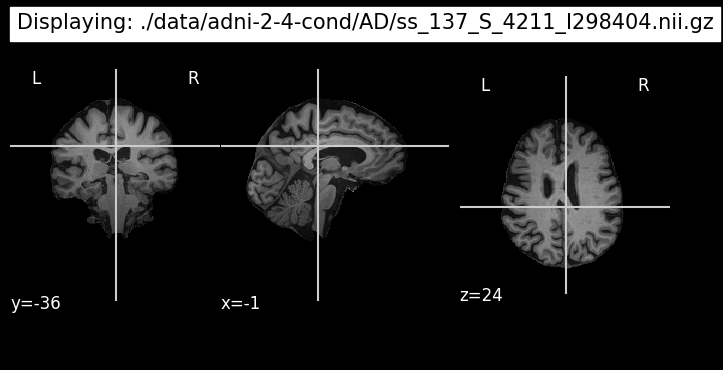


Grid Display for Dimensions:


,Dimension,Frequency,Percentage
10,"(176, 240, 256)",287,31.8
11,"(211, 240, 256)",284,31.5
5,"(170, 256, 256)",144,16.0
6,"(204, 256, 256)",144,16.0
0,"(192, 240, 240)",14,1.6
3,"(160, 192, 192)",14,1.6
7,"(211, 253, 270)",5,0.6
1,"(176, 248, 256)",2,0.2
2,"(211, 248, 256)",2,0.2
8,"(160, 240, 256)",2,0.2



Grid Display for Voxel Sizes:


,Voxel Size,Frequency,Percentage
12,"(1.0, 1.0, 1.0)",452,50.1
2,"(1.1999999, 1.0, 1.0)",285,31.6
5,"(1.199997, 1.0, 1.0)",86,9.5
9,"(1.2000046, 1.0, 1.0)",52,5.8
4,"(1.2, 1.25, 1.25)",14,1.6
6,"(1.1999999, 1.0546875, 1.0546875)",5,0.6
1,"(1.2, 1.0, 1.0)",2,0.2
0,"(1.2000003, 1.0, 1.0)",1,0.1
3,"(1.2000021, 1.0, 1.0)",1,0.1
7,"(1.200004, 1.0, 1.0)",1,0.1



Grid Display for Orientations:


,Orientation,Frequency,Percentage
0,"(L, A, S)",902,100.0



Grid Display for Prefix Counts:


,Prefix,Count
0,resampled,451.0
Total,NaN,451.0


Analysing files with prefix ''


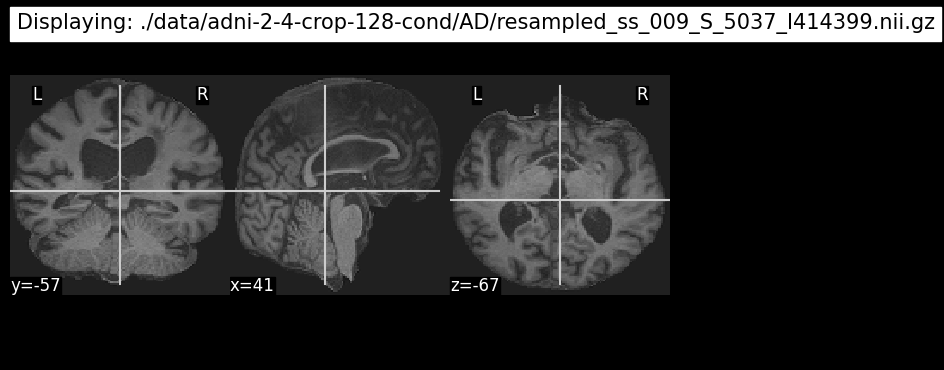


Grid Display for Dimensions:


,Dimension,Frequency,Percentage
0,"(128, 128, 128)",451,100.0



Grid Display for Voxel Sizes:


,Voxel Size,Frequency,Percentage
1,"(1.0, 1.0, 1.0)",449,99.6
0,"(0.99999994, 1.0, 1.0)",2,0.4



Grid Display for Orientations:


,Orientation,Frequency,Percentage
0,"(L, A, S)",451,100.0


In [ ]:
batch_preprocess_mri_dataset(
    "./data/adni-2-4-cond",
    "./data/adni-2-4-crop-128-cond",
    target_shape=(128, 128, 128),
)

display_comprehensive_stats("./data/adni-2-4-cond")


Grid Display for Prefix Counts:


,Prefix,Count
0,resampled,451.0
Total,NaN,451.0


Analysing files with prefix ''


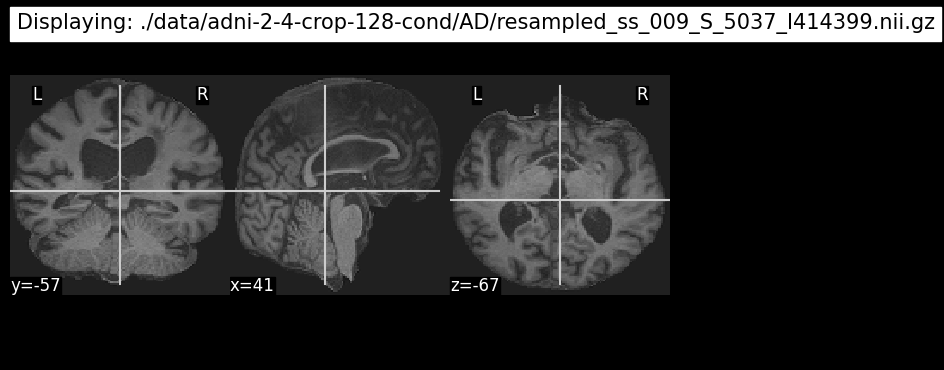


Grid Display for Dimensions:


,Dimension,Frequency,Percentage
0,"(128, 128, 128)",451,100.0



Grid Display for Voxel Sizes:


,Voxel Size,Frequency,Percentage
1,"(1.0, 1.0, 1.0)",449,99.6
0,"(0.99999994, 1.0, 1.0)",2,0.4



Grid Display for Orientations:


,Orientation,Frequency,Percentage
0,"(L, A, S)",451,100.0


In [46]:
display_comprehensive_stats("./data/adni-2-4-crop-128-cond")

# Bias Field Correction


Bias-corrected image saved to: ./data/adni-2-4-crop-128-cond/AD/009_S_5037_I414399.nii.gz
Bias-corrected image saved to: ./data/adni-2-4-crop-128-cond/AD/036_S_5063_I355515.nii.gz
Bias-corrected image saved to: ./data/adni-2-4-crop-128-cond/AD/009_S_5027_I406893.nii.gz
Bias-corrected image saved to: ./data/adni-2-4-crop-128-cond/AD/036_S_4820_I358134.nii.gz
Bias-corrected image saved to: ./data/adni-2-4-crop-128-cond/AD/011_S_4912_I346989.nii.gz
Bias-corrected image saved to: ./data/adni-2-4-crop-128-cond/AD/037_S_4770_I382798.nii.gz
Bias-corrected image saved to: ./data/adni-2-4-crop-128-cond/AD/135_S_5015_I399473.nii.gz
Bias-corrected image saved to: ./data/adni-2-4-crop-128-cond/AD/019_S_5019_I358814.nii.gz
Bias-corrected image saved to: ./data/adni-2-4-crop-128-cond/AD/067_S_5205_I389098.nii.gz
Bias-corrected image saved to: ./data/adni-2-4-crop-128-cond/AD/135_S_4657_I342900.nii.gz
Bias-corrected image saved to: ./data/adni-2-4-crop-128-cond/AD/123_S_4526_I416335.nii.gz
Bias-corre

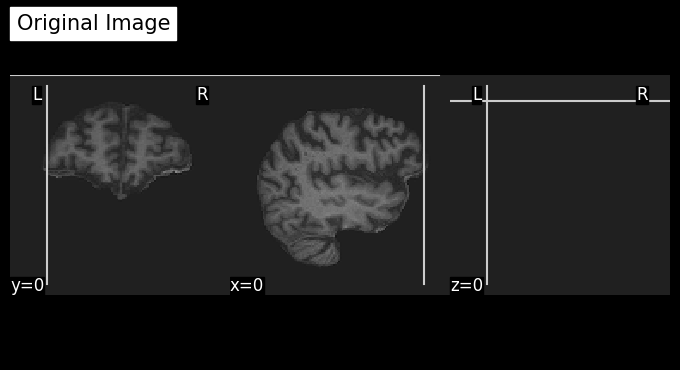

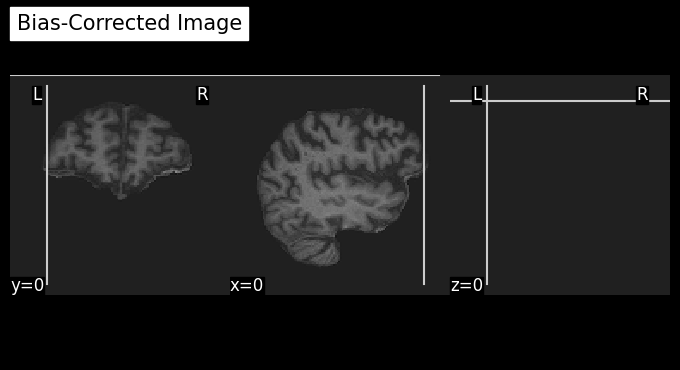

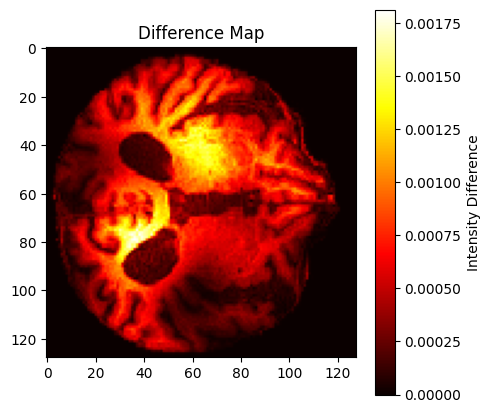

In [47]:
# Get all skull-stripped files
nii_files = get_nii_files("./data/adni-2-4-crop-128-cond", "resampled_ss_")

# Apply N4 Bias Field Correction to all files
for file in nii_files:
    bias_corrected_path = file.replace("resampled_ss_", "")

    if not os.path.exists(bias_corrected_path):
        # Load the skull-stripped image
        input_image = ants.image_read(file)

        # Apply N4 Bias Field Correction
        bias_corrected = ants.n4_bias_field_correction(input_image)

        # Save the bias-corrected image
        ants.image_write(bias_corrected, bias_corrected_path)
        print(f"Bias-corrected image saved to: {bias_corrected_path}")
    else:
        print(f"Skipping {file}, bias-corrected file already exists.")

# Load one bias-corrected image for comparison
if len(nii_files) >= 1:
    original_image = nib.load(nii_files[0])
    bias_corrected_image = nib.load(nii_files[0].replace("resampled_ss_", ""))

    # Plot the middle slice of the original scan
    plotting.plot_anat(original_image, title="Original Image", cut_coords=(0, 0, 0))
    plt.show()

    # Plot the middle slice of the bias-corrected scan
    plotting.plot_anat(
        bias_corrected_image, title="Bias-Corrected Image", cut_coords=(0, 0, 0)
    )
    plt.show()

    # Convert to numpy arrays
    original_data = original_image.get_fdata()
    bias_corrected_data = bias_corrected_image.get_fdata()

    # Choose a slice index
    slice_idx = original_data.shape[2] // 2  # Middle slice

    # Compute absolute difference
    difference = np.abs(
        original_data[:, :, slice_idx] - bias_corrected_data[:, :, slice_idx]
    )

    # Plot difference heatmap
    plt.figure(figsize=(5, 5))
    plt.imshow(difference, cmap="hot")
    plt.colorbar(label="Intensity Difference")
    plt.title("Difference Map")
    plt.show()
else:
    print("Not enough files for comparison.")

# Final Preprocessing Clean



Grid Display for Prefix Counts:


,Prefix,Count
2,resampled,451.0
4,130,43.0
0,135,25.0
22,116,25.0
8,019,23.0
28,137,23.0
19,006,22.0
11,037,20.0
26,036,20.0
1,011,18.0


Analysing files with prefix ''


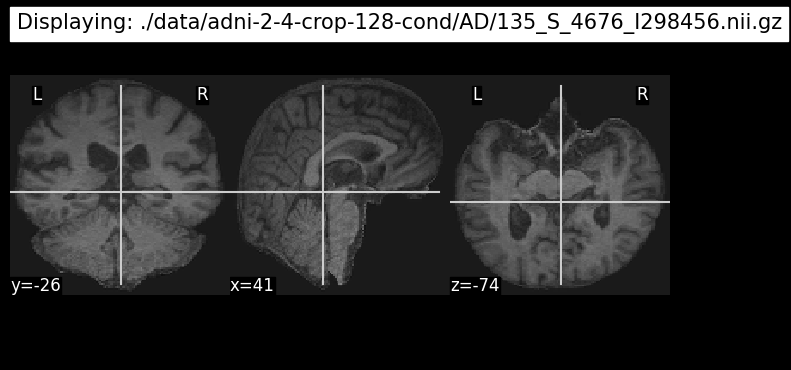


Grid Display for Dimensions:


,Dimension,Frequency,Percentage
0,"(128, 128, 128)",902,100.0



Grid Display for Voxel Sizes:


,Voxel Size,Frequency,Percentage
1,"(1.0, 1.0, 1.0)",898,99.6
0,"(0.99999994, 1.0, 1.0)",4,0.4



Grid Display for Orientations:


,Orientation,Frequency,Percentage
0,"(L, A, S)",902,100.0


In [48]:
display_comprehensive_stats("./data/adni-2-4-crop-128-cond")

In [49]:
def remove_resampled_files(base_dir):
    """Remove all files that begin with 'resampled_'."""
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.startswith("resampled_"):
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Removed: {file_path}")


remove_resampled_files("./data/adni-2-4-crop-128-cond")

Removed: ./data/adni-2-4-crop-128-cond/AD/resampled_ss_009_S_5037_I414399.nii.gz
Removed: ./data/adni-2-4-crop-128-cond/AD/resampled_ss_036_S_5063_I355515.nii.gz
Removed: ./data/adni-2-4-crop-128-cond/AD/resampled_ss_009_S_5027_I406893.nii.gz
Removed: ./data/adni-2-4-crop-128-cond/AD/resampled_ss_036_S_4820_I358134.nii.gz
Removed: ./data/adni-2-4-crop-128-cond/AD/resampled_ss_011_S_4912_I346989.nii.gz
Removed: ./data/adni-2-4-crop-128-cond/AD/resampled_ss_037_S_4770_I382798.nii.gz
Removed: ./data/adni-2-4-crop-128-cond/AD/resampled_ss_135_S_5015_I399473.nii.gz
Removed: ./data/adni-2-4-crop-128-cond/AD/resampled_ss_019_S_5019_I358814.nii.gz
Removed: ./data/adni-2-4-crop-128-cond/AD/resampled_ss_067_S_5205_I389098.nii.gz
Removed: ./data/adni-2-4-crop-128-cond/AD/resampled_ss_135_S_4657_I342900.nii.gz
Removed: ./data/adni-2-4-crop-128-cond/AD/resampled_ss_123_S_4526_I416335.nii.gz
Removed: ./data/adni-2-4-crop-128-cond/AD/resampled_ss_036_S_5210_I376435.nii.gz
Removed: ./data/adni-2-4-cro


Grid Display for Prefix Counts:


,Prefix,Count
12,023,124.0
2,011,65.0
4,067,58.0
36,036,55.0
3,013,51.0
26,116,48.0
28,099,44.0
5,130,43.0
13,033,40.0
17,141,39.0


Analysing files with prefix ''


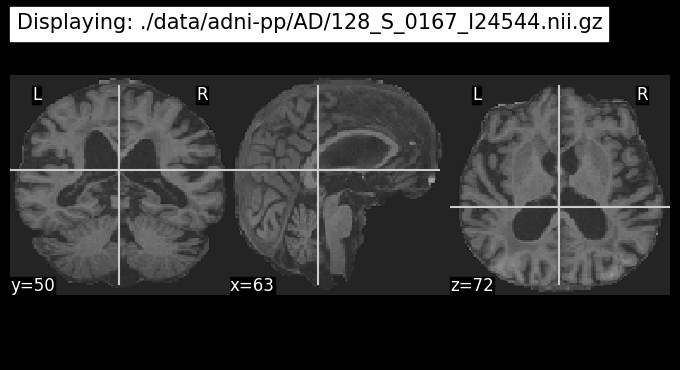


Grid Display for Dimensions:


,Dimension,Frequency,Percentage
0,"(128, 128, 128)",1300,100.0



Grid Display for Voxel Sizes:


,Voxel Size,Frequency,Percentage
1,"(1.0, 1.0, 1.0)",1298,99.8
0,"(0.99999994, 1.0, 1.0)",2,0.2



Grid Display for Orientations:


,Orientation,Frequency,Percentage
0,"(R, A, S)",849,65.3
1,"(L, A, S)",451,34.7


In [51]:
display_comprehensive_stats("./data/adni-pp")

In [ ]:
def standardize_mri_orientation(input_path):
    """
    Loads an MRI scan, standardizes its orientation to RAS (if needed),
    and saves the resulting image.

    Parameters:
    -----------
    input_path : str
        Path to the input MRI file.
    """
    # Load the image
    img = nib.load(input_path)

    # Display current orientation for reference
    current_orient = nib.aff2axcodes(img.affine)
    print(f"Current orientation for {input_path}: {current_orient}")

    # If already in RAS, skip processing
    if current_orient == ("R", "A", "S"):
        print(f"{input_path} is already in RAS orientation. Skipping.")
        return

    # Convert the image to its canonical (RAS) orientation
    canonical_img = nib.as_closest_canonical(img)
    new_orient = nib.aff2axcodes(canonical_img.affine)
    print(f"Standardized orientation for {input_path}: {new_orient}")

    # Save the standardized image
    nib.save(canonical_img, input_path)
    print(f"Saved standardized image to {input_path}")


def batch_standardize_orientation(input_dir):
    """
    Batch process all NIfTI files in the input directory by standardizing their orientation to RAS.
    The standardized images are saved with the prefix 'std_' in the same directory.
    """
    nii_files = get_nii_files(input_dir)
    for nii_file in nii_files:
        print(f"Standardizing orientation for {nii_file}")
        standardize_mri_orientation(nii_file)


Grid Display for Prefix Counts:


,Prefix,Count
12,023,124.0
2,011,65.0
4,067,58.0
36,036,55.0
3,013,51.0
26,116,48.0
28,099,44.0
5,130,43.0
13,033,40.0
17,141,39.0


Analysing files with prefix ''


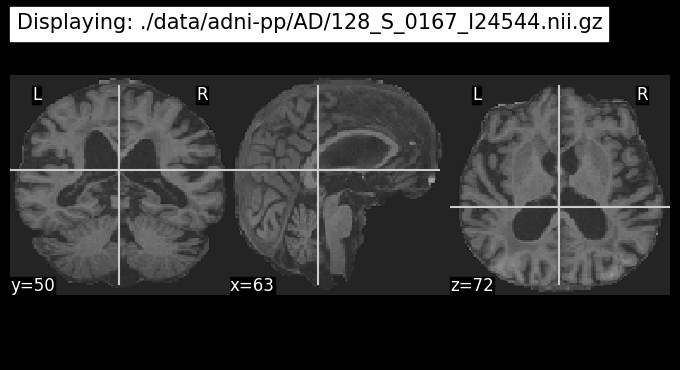


Grid Display for Dimensions:


,Dimension,Frequency,Percentage
0,"(128, 128, 128)",1300,100.0



Grid Display for Voxel Sizes:


,Voxel Size,Frequency,Percentage
1,"(1.0, 1.0, 1.0)",1298,99.8
0,"(0.99999994, 1.0, 1.0)",2,0.2



Grid Display for Orientations:


,Orientation,Frequency,Percentage
0,"(R, A, S)",849,65.3
1,"(L, A, S)",451,34.7


Standardizing orientation for ./data/adni-pp/AD/128_S_0167_I24544.nii.gz
Current orientation for ./data/adni-pp/AD/128_S_0167_I24544.nii.gz: ('R', 'A', 'S')
./data/adni-pp/AD/128_S_0167_I24544.nii.gz is already in RAS orientation. Skipping.
Standardizing orientation for ./data/adni-pp/AD/135_S_4676_I298456.nii.gz
Current orientation for ./data/adni-pp/AD/135_S_4676_I298456.nii.gz: ('L', 'A', 'S')
Standardized orientation for ./data/adni-pp/AD/135_S_4676_I298456.nii.gz: ('R', 'A', 'S')
Saved standardized image to ./data/adni-pp/AD/135_S_4676_I298456.nii.gz
Standardizing orientation for ./data/adni-pp/AD/011_S_4912_I363474.nii.gz
Current orientation for ./data/adni-pp/AD/011_S_4912_I363474.nii.gz: ('L', 'A', 'S')
Standardized orientation for ./data/adni-pp/AD/011_S_4912_I363474.nii.gz: ('R', 'A', 'S')
Saved standardized image to ./data/adni-pp/AD/011_S_4912_I363474.nii.gz
Standardizing orientation for ./data/adni-pp/AD/013_S_5071_I373419.nii.gz
Current orientation for ./data/adni-pp/AD/0

,Prefix,Count
12,023,124.0
2,011,65.0
4,067,58.0
36,036,55.0
3,013,51.0
26,116,48.0
28,099,44.0
5,130,43.0
13,033,40.0
17,141,39.0


Analysing files with prefix ''


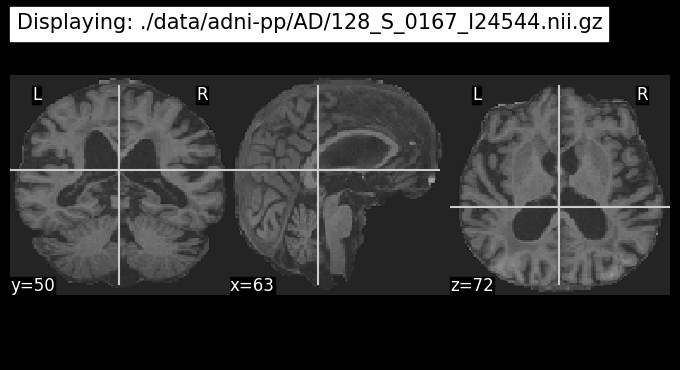


Grid Display for Dimensions:


,Dimension,Frequency,Percentage
0,"(128, 128, 128)",1300,100.0



Grid Display for Voxel Sizes:


,Voxel Size,Frequency,Percentage
3,"(1.0, 1.0, 1.0)",1296,99.7
0,"(0.9999999, 1.0, 1.0)",1,0.1
1,"(0.99999994, 1.0, 1.0)",1,0.1
2,"(1.0, 1.0, 0.99999994)",1,0.1
4,"(1.0, 0.99999994, 1.0)",1,0.1



Grid Display for Orientations:


,Orientation,Frequency,Percentage
0,"(R, A, S)",1300,100.0


In [ ]:
display_comprehensive_stats("./data/adni-pp")
batch_standardize_orientation("./data/adni-pp")
display_comprehensive_stats("./data/adni-pp")

# Create the Split Dataset


In [63]:
def split_data_by_subject(
    data_dir, output_dir, train_pct=0.8, val_pct=0.1, test_pct=0.1, random_seed=42
):
    """
    Reads data from data_dir where subdirectories 'AD' and 'CN' contain scans.
    Splits scans into train/val/test sets (80/10/10 by scan counts) ensuring that
    each subject is unique to a split.

    Args:
        data_dir (str): Directory containing 'AD' and 'CN' folders with scan files.
        output_dir (str): Directory where train/val/test folders will be created.
        train_pct (float): Proportion of scans for training.
        val_pct (float): Proportion of scans for validation.
        test_pct (float): Proportion of scans for testing.
        random_seed (int): Seed for reproducibility.
    """
    random.seed(random_seed)
    if abs(train_pct + val_pct + test_pct - 1.0) > 0.001:
        raise ValueError("Split percentages must sum to 1.0")

    # Setup output directories for each split and condition
    for split in ["train", "val", "test"]:
        for condition in ["AD", "CN"]:
            os.makedirs(os.path.join(output_dir, split, condition), exist_ok=True)

    # Dictionaries to store subject information and total scans
    subject_to_scans = defaultdict(list)  # key: subject_id, value: list of file info
    subjects_by_condition = defaultdict(list)
    total_scans_by_condition = defaultdict(int)

    # Process each condition directory
    for condition in ["AD", "CN"]:
        condition_dir = os.path.join(data_dir, condition)
        if not os.path.exists(condition_dir):
            continue

        for file_path in glob.glob(os.path.join(condition_dir, "*.nii.gz")):
            file_name = os.path.basename(file_path)
            if "_" not in file_name:
                continue
            # Assume file name is like: "013_S_0575_I44926.nii.gz"
            parts = file_name.split("_")
            subject_id = "_".join(parts[:3])
            scan_id = parts[-1].split(".")[0]

            # List subject only once per condition
            if subject_id not in subjects_by_condition[condition]:
                subjects_by_condition[condition].append(subject_id)

            subject_to_scans[subject_id].append(
                {
                    "scan_id": scan_id,
                    "condition": condition,
                    "filename": file_name,
                    "original_path": file_path,
                }
            )
            total_scans_by_condition[condition] += 1

    # Create new splits per condition based on scan counts
    new_splits = {}
    for condition in subjects_by_condition:
        subjects = subjects_by_condition[condition].copy()
        random.shuffle(subjects)
        # Sort subjects in ascending order so that subjects with fewer scans come first
        subjects_sorted = sorted(subjects, key=lambda s: len(subject_to_scans[s]))

        total_scans = total_scans_by_condition[condition]
        target_train = int(total_scans * train_pct)
        target_val = int(total_scans * val_pct)
        target_test = total_scans - target_train - target_val

        print(f"\nCondition: {condition}")
        print(
            f"Target scan counts -> Train: {target_train}, Val: {target_val}, Test: {target_test}"
        )

        new_splits[condition] = {"train": [], "val": [], "test": []}
        current_counts = {"train": 0, "val": 0, "test": 0}

        # First, try to assign subjects to test split
        remaining_subjects = []
        for subject in subjects_sorted:
            scount = len(subject_to_scans[subject])
            if (
                current_counts["test"] < target_test
                and (current_counts["test"] + scount) <= target_test * 1.1
            ):
                new_splits[condition]["test"].append(subject)
                current_counts["test"] += scount
            else:
                remaining_subjects.append(subject)

        # Next, assign subjects to validation split
        subjects_for_train = []
        for subject in remaining_subjects:
            scount = len(subject_to_scans[subject])
            if (
                current_counts["val"] < target_val
                and (current_counts["val"] + scount) <= target_val * 1.1
            ):
                new_splits[condition]["val"].append(subject)
                current_counts["val"] += scount
            else:
                subjects_for_train.append(subject)

        # Remaining subjects go to training split
        for subject in subjects_for_train:
            new_splits[condition]["train"].append(subject)
            current_counts["train"] += len(subject_to_scans[subject])

        print("Actual split scan counts:")
        for split in ["train", "val", "test"]:
            print(
                f"  {split}: {current_counts[split]} scans over {len(new_splits[condition][split])} subjects"
            )

    # Copy the scans to the output directory maintaining new split structure.
    copied_files = 0
    for subject, scans in subject_to_scans.items():
        for scan in scans:
            condition = scan["condition"]
            target_split = None
            # Determine which split the subject belongs to for the condition
            for split in ["train", "val", "test"]:
                if subject in new_splits[condition][split]:
                    target_split = split
                    break
            if target_split:
                dst_path = os.path.join(
                    output_dir, target_split, condition, scan["filename"]
                )
                shutil.copy2(scan["original_path"], dst_path)
                copied_files += 1
    print(f"\nCopied {copied_files} files into split directories.")

    # Print subject counts for each split and condition
    print("\nFinal subject counts per condition:")
    for condition in new_splits:
        print(f"Condition {condition}:")
        for split in new_splits[condition]:
            print(f"  {split}: {len(new_splits[condition][split])} subjects")


if __name__ == "__main__":
    # Example usage:
    input_dir = "./data/adni-pp"  # This directory should contain AD and CN folders
    output_dir = (
        "./data/adni-split-asc"  # Output directory to create train/val/test splits
    )
    split_data_by_subject(input_dir, output_dir)


Condition: AD
Target scan counts -> Train: 520, Val: 65, Test: 65
Actual split scan counts:
  train: 520 scans over 121 subjects
  val: 65 scans over 26 subjects
  test: 65 scans over 56 subjects

Condition: CN
Target scan counts -> Train: 520, Val: 65, Test: 65
Actual split scan counts:
  train: 519 scans over 91 subjects
  val: 66 scans over 49 subjects
  test: 65 scans over 65 subjects

Copied 1300 files into split directories.

Final subject counts per condition:
Condition AD:
  train: 121 subjects
  val: 26 subjects
  test: 56 subjects
Condition CN:
  train: 91 subjects
  val: 49 subjects
  test: 65 subjects
